In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
from typing import List
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

mi.set_variant('scalar_rgb')

In [2]:
######################################## PATH GRAPH ###################################################

class LightEdge:
    def __init__(self, nodeID:int, radiance:mi.Color3f, pdf:float, mis:float):
        self.nodeId = nodeID    #用于快速查询对应节点,记录的发出这条边的节点ID
        self.radiance:mi.Color3f = radiance  #边上的权重
        self.pdf = pdf  #采样边的pdf
        self.direction:mi.Vector3f = mi.Vector3f(0.0)
        self.mis = mis

class ContinueEdge:
    def __init__(self, nodeID:int, radiance:mi.Color3f, pdf:float, index:int):
        self.nodeId = nodeID
        self.radiance:mi.Color3f = radiance  #边上的权重
        self.radiance_Ld:mi.Color3f = mi.Color3f(0.0)
        self.pdf = pdf  #采样的pdf
        self.direction:mi.Vector3f = mi.Vector3f(0.0)
        self.index = index
    
    def copy(self):
        edge:ContinueEdge = ContinueEdge(self.nodeId, self.radiance, self.pdf, self.index)
        edge.radiance_Ld = self.radiance_Ld
        return edge

class Node:
    def __init__(self, si:mi.SurfaceInteraction3f, ID:int, isShadingPoints:bool):
        self.LE = []     #光边，进入该节点
        self.CE:int = -1     #连续边,进入该节点
        self.si:mi.SurfaceInteraction3f = si #交点信息
        self.shadingPoints = isShadingPoints
        self.ID = ID
        self.outCE:int = -1 #记录出边
    
    def add_LE(self, le:LightEdge):
        self.LE.append(le)
    
    def add_CE(self, ce:ContinueEdge):
        self.CE.append(ce)
    
class PathGraph:
    def __init__(self):
        self.Nodes:List[Node] = [] #节点
        self.ContinueEdges:List[ContinueEdge] = []
        self.CurIndex = 0
        self.CEIndex = 0
        self.shadingPoints:List[int] = []   #记录着色点编号

    def addNode(self, node:Node):
        self.Nodes.append(node)
        self.CurIndex += 1
    
    def addCE(self, ce:ContinueEdge):
        self.ContinueEdges.append(ce)
        self.CEIndex += 1
    
    def Lenth(self):
        return len(self.Nodes)

# class Cluster:  #节点簇
#     def __init__(self, PathGraph:PathGraph):
#         self.indices_NODES = 
pathGraph = PathGraph()


In [3]:
################################### Renderer ############################################
class PTRenderer:
    def __init__(self, max_depth = 6):
        self.max_depth = max_depth
        pass

    def GenerateRays(self, scene:mi.Scene, sensor:mi.Sensor, sampler:mi.Sampler, idx:mi.UInt):
            film = sensor.film()
            film_size = film.crop_size()
            rfilter = film.rfilter()
            border_size = rfilter.border_size()

            if film.sample_border():
                    film_size += 2 * border_size

            spp = 1

            log_spp = dr.log2i(spp)
            if 1 << log_spp == spp:
                idx >>= dr.opaque(mi.UInt32, log_spp)
            else:
                idx //= dr.opaque(mi.UInt32, spp)
            # Compute the position on the image plane
            pos = mi.Vector2i()
            pos.y = idx // film_size[0]
            pos.x = dr.fma(mi.UInt32(mi.Int32(-film_size[0])), pos.y, idx)
            if film.sample_border():
                pos -= border_size
            pos += mi.Vector2i(film.crop_offset())
            # Cast to floating point and add random offset
            pos_f = mi.Vector2f(pos) + sampler.next_2d()

            # Re-scale the position to [0, 1]^2
            scale = dr.rcp(mi.ScalarVector2f(film.crop_size()))
            offset = -mi.ScalarVector2f(film.crop_offset()) * scale
            pos_adjusted = dr.fma(pos_f, scale, offset)

            aperture_sample = mi.Vector2f(0.0)
            if sensor.needs_aperture_sample():
                aperture_sample = sampler.next_2d()

            wavelength_sample = 0
            if mi.is_spectral:
                wavelength_sample = sampler.next_1d()

            time = sensor.shutter_open()
            if sensor.shutter_open_time() > 0:
                time += sampler.next_1d() * sensor.shutter_open_time()

            with dr.resume_grad():
                    ray, weight = sensor.sample_ray_differential(
                        time=time,
                        sample1=wavelength_sample,
                        sample2=pos_adjusted,
                        sample3=aperture_sample
                    )
            splatting_pos = mi.Vector2f(pos) if rfilter.is_box_filter() else pos_f
            return ray, weight, splatting_pos
    
    def traceOneRay(self, scene: mi.Scene, sampler, ray: mi.RayDifferential3f, active: bool = True):

        bsdf_ctx = mi.BSDFContext()
        ray = mi.Ray3f(ray)
        depth = mi.UInt32(0)
        L = mi.Color3f(0.0)
        beta = mi.Color3f(1.0)
        active = mi.Bool(active)
        
        prev_bsdf_delta = mi.Bool(True)
        prev_si:mi.SurfaceInteraction3f = mi.SurfaceInteraction3f()
        prev_bsdf_pdf = mi.Float(1.0)
        nodes:List[Node] = []  # 保存某个路径的所有节点
        betas:List[float] = []  # 每个顶点开始的权重

        while active:

            active_next = mi.Bool(active)

            # get interactions
            si:mi.SurfaceInteraction3f = scene.ray_intersect(ray)

            # 无效交点
            if not si.is_valid():
                if depth == 0:
                    nullNode = Node(si, pathGraph.CurIndex, (depth == 0))
                    pathGraph.addNode(nullNode)
                    pathGraph.shadingPoints.append(nullNode.ID)
                break
            
            # 创建图节点及连续边
            curNode = Node(si, pathGraph.CurIndex, (depth == 0))
            if depth != 0:
                 curNode.outCE = nodes[depth - 1].CE
            if depth == 0:
                 pathGraph.shadingPoints.append(curNode.ID)
                 
            ce = ContinueEdge(-1, mi.Color3f(0.0), 0.0, pathGraph.CEIndex) # nodeID需要下一次进行更新,记录的是下一个顶点的ID
            pathGraph.addCE(ce)
            curNode.CE = ce.index
            # 更新上一个节点的连续边ID
            if depth > 0:
                pathGraph.ContinueEdges[nodes[depth - 1].CE].nodeId = curNode.ID

            nodes.append(curNode)
            betas.append(1.0)

            bsdf:mi.BSDF = si.bsdf()
            
            # --------------------- 当前交点命中光源 ------------------------
            L_light = mi.Color3f(0.0)
            mis = mi.Float(0.0)
            emitter = si.emitter(scene)

            if emitter != None:
                
                L_light = emitter.eval(si)

                pdf_emitter = 0

                ds = mi.DirectionSample3f(scene, si, prev_si)
                pdf_emitter = scene.pdf_emitter_direction(prev_si, ds)
                mis = self.mis_weight(prev_bsdf_pdf, pdf_emitter)

                # 记录一条光边, 而且上一个交点不能是delta，否则无法复用
                if depth != 0 and not prev_bsdf_delta:
                    le = LightEdge(curNode.ID, L_light, prev_bsdf_pdf, mis)
                    le.direction = si.to_world(si.wi)
                    nodes[depth - 1].add_LE(le)
            
            Le = beta * L_light * mis

            # 更新每条连续边的radiance值
            for i in range(depth):
                pathGraph.ContinueEdges[nodes[i].CE].radiance += betas[i] * L_light * mis

            # # --------------------- 光源采样 ------------------------

            # continue tracing to reach more vertex ?
            active_next &= (depth + 1 < self.max_depth) & si.is_valid()
            # Is emitter sampling possible on the current vertex?
            active_em = active_next & mi.has_flag(bsdf.flags(),mi.BSDFFlags.Smooth)

            # 采样光源
            ds, em_weight = scene.sample_emitter_direction(si, sampler.next_2d(), True, active_em)
            active_em &= dr.neq(ds.pdf, 0.0)

            # evaluate BSDF*cos(theta)
            wo = si.to_local(ds.d)
            bsdf_value_em , bsdf_pdf_em = bsdf.eval_pdf(bsdf_ctx, si, wo, active_em)
            mis_em = 1
            if not ds.delta and active_em:
                 mis_em = self.mis_weight(ds.pdf, bsdf_pdf_em)
            Lr_dir = beta  * bsdf_value_em * em_weight * mis_em

            # 记录一条光边
            if active_em:
                 le = LightEdge(curNode.ID, em_weight * ds.pdf, ds.pdf, mis_em)
                 le.direction = ds.d    # 世界坐标
                 curNode.add_LE(le)
                 
            # 记录出射边的Ld
            pathGraph.ContinueEdges[curNode.outCE].radiance_Ld = bsdf_value_em * em_weight * mis_em

            # 更新每条连续边的值
            for i in range(depth):
                pathGraph.ContinueEdges[nodes[i].CE].radiance += betas[i] * bsdf_value_em * em_weight * mis_em

            # # # --------------------- bsdf sampling -----------------------

            # bsdf_weight : bsdf_val*cosθ / pdf
            bsdf_sample, bsdf_weight = bsdf.sample(bsdf_ctx, si, sampler.next_1d(), sampler.next_2d(), active_next)

            # # # --------------------- update the variables --------------------------

            L = L  + Le + Lr_dir
            ray = si.spawn_ray(si.to_world(bsdf_sample.wo)) #generate rays for next iteration
            beta *= bsdf_weight # update β
            
            # 记录这条边的pdf
            pathGraph.ContinueEdges[curNode.CE].pdf = bsdf.pdf(bsdf_ctx, si, bsdf_sample.wo)
            pathGraph.ContinueEdges[curNode.CE].direction = si.to_world(bsdf_sample.wo)
            
            # 更新所有连续边的beta
            for i in range(depth):
                betas[i] *= bsdf_weight
            betas[depth] *= bsdf_weight

            prev_si = si
            prev_bsdf_pdf = bsdf_sample.pdf
            prev_bsdf_delta = mi.has_flag(bsdf_sample.sampled_type, mi.BSDFFlags.Delta)

            depth += 1

            active = active_next

        for node in nodes:
            pathGraph.addNode(node)
            
        return L

    def sample(self, scene: mi.Scene, sampler, ray: mi.RayDifferential3f, medium: mi.Medium = None, active: bool = True):

        bsdf_ctx = mi.BSDFContext()
        ray = mi.Ray3f(ray)
        depth = mi.UInt32(0)
        L = mi.Color3f(0.0)
        beta = mi.Color3f(1.0)
        active = mi.Bool(active)

        prev_bsdf_delta = mi.Bool(True)
        prev_si = dr.zeros(mi.SurfaceInteraction3f)
        prev_bsdf_pdf = mi.Float(1.0)
        
        pathGraph = PathGraph()

        loop = mi.Loop(name="PathInfoGather",state=lambda:(sampler,L,depth,ray,beta,active,prev_bsdf_delta,prev_si,prev_bsdf_pdf))

        while loop(active):

            active_next = mi.Bool(active)

            # get interactions
            si = scene.ray_intersect(ray)

            # 处理散射事件
            bsdf = si.bsdf(ray)
            
            # --------------------- 当前交点命中光源 ------------------------

            ds = mi.DirectionSample3f(scene, si, prev_si)
            mis = self.mis_weight(prev_bsdf_pdf, scene.pdf_emitter_direction(prev_si, ds, ~prev_bsdf_delta))
            L_light = si.emitter(scene).eval(si)
            Le = beta * L_light * mis


            # --------------------- emitter sampling ------------------------

            # continue tracing to reach more vertex ?
            active_next &= (depth + 1 < self.max_depth) & si.is_valid()
            # Is emitter sampling possible on the current vertex?
            active_em = active_next & mi.has_flag(bsdf.flags(),mi.BSDFFlags.Smooth)
            # sample the emitters
            ds,em_weight = scene.sample_emitter_direction(si,sampler.next_2d(),True,active_em)
            active_em &= dr.neq(ds.pdf,0.0)

            #evaluate BSDF*cos(theta)
            wo = si.to_local(ds.d)
            bsdf_value_em , bsdf_pdf_em = bsdf.eval_pdf(bsdf_ctx,si,wo,active_em)
            mis_em = dr.select(ds.delta, 1, self.mis_weight(ds.pdf, bsdf_pdf_em))
            Lr_dir = beta  * bsdf_value_em * em_weight * mis_em

            # --------------------- bsdf sampling -----------------------

            # bsdf_weight : bsdf_val*cosθ / pdf
            bsdf_sample, bsdf_weight = bsdf.sample(bsdf_ctx,si,sampler.next_1d(),sampler.next_2d(),active_next)

            # --------------------- update the variables --------------------------

            L = L  + Le + Lr_dir
            ray = si.spawn_ray(si.to_world(bsdf_sample.wo)) #generate rays for next iteration
            beta *= bsdf_weight # update β

            prev_si = si
            prev_bsdf_pdf = bsdf_sample.pdf
            prev_bsdf_delta = mi.has_flag(bsdf_sample.sampled_type,mi.BSDFFlags.Delta)

            beta_max = dr.max(beta)
            active_next &= dr.neq(beta_max,0.0)
            depth_count = si.is_valid() & dr.neq(prev_bsdf_delta,True)
            depth[depth_count] += 1

            active = active_next

        return L

    def mis_weight(self, pdf_a, pdf_b):
        """
        Compute the Multiple Importance Sampling (MIS) weight given the densities
        of two sampling strategies according to the power heuristic.
        """
        a2 = pdf_a*pdf_a
        b2 = pdf_b*pdf_b
        w = a2 / (a2 + b2)
        return dr.select(dr.isfinite(w), w, 0)

In [4]:
# scene:mi.Scene = mi.load_dict(mi.cornell_box())
scene:mi.Scene = mi.load_file("./complex_scenes/classroom/classroom/scene_v3.xml")
sensor:mi.Sensor = scene.sensors()[0]
sampler:mi.Sampler = mi.load_dict({
    'type':'independent',
    'sample_count':1
})
sampler.seed(0, 256*256)

# integrator:mi.SamplingIntegrator = mi.load_dict({
#     'type':'path',
#     'max_depth':3
# })

pt = PTRenderer(max_depth = 6)

L = []
for i in range(256 * 256):
    ray, weight, _ = pt.GenerateRays(scene, sensor, sampler, i)
    results = pt.traceOneRay(scene, sampler, ray)
    L.append(results)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.8403683].


(-0.5, 255.5, 255.5, -0.5)

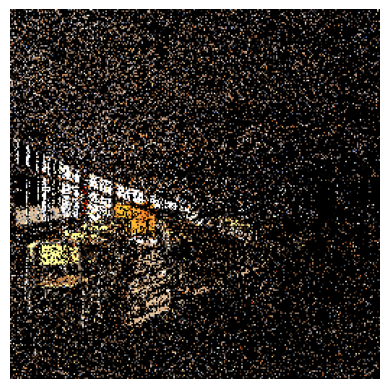

In [5]:
L = np.array(L)
L = L.reshape((256, 256, 3))

import matplotlib.pyplot as plt

plt.imshow(L**(1.0/2.2)); plt.axis('off')

In [6]:

def ReConstructImgByPathGraph(paghGraph:PathGraph):
    L = []
    for idx in pathGraph.shadingPoints:
        node:Node = pathGraph.Nodes[idx]
        curL = mi.Color3f(0.0)
        if not node.si.is_valid():
            L.append(mi.Color3f(0.0))
            continue
        # 取出连续边
        CE = pathGraph.ContinueEdges[node.CE]
        bsdf:mi.BSDF = node.si.bsdf()
        pdf_sum = 0.0

        # 计算光边的pdf和
        for le in node.LE:
            pdf_sum += le.pdf

        if pdf_sum != 0:
            for le in node.LE:
                bsdf_val = bsdf.eval(mi.BSDFContext(), node.si, node.si.to_local(le.direction))
                curL += (bsdf_val * le.radiance * le.mis) / pdf_sum
            
        bsdf_val, pdf = bsdf.eval_pdf(mi.BSDFContext(), node.si, node.si.to_local(CE.direction))
        if CE.pdf != 0.0:
            curL += (bsdf_val * CE.radiance) / pdf  
        
        L.append(curL)

    L = np.array(L)
    L = L.reshape((256, 256, 3))
    return L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.8403683].


(-0.5, 255.5, 255.5, -0.5)

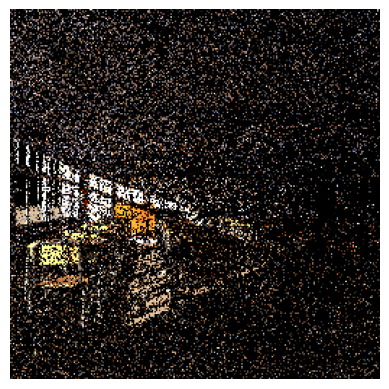

In [7]:
L = ReConstructImgByPathGraph(pathGraph)
plt.imshow(L**(1.0/2.2)); plt.axis('off')

In [8]:
CLUSTER_SIZE = 32   # 每个簇的大小
CLUSTER_NUM = pathGraph.Lenth() // CLUSTER_SIZE

In [9]:
from scipy.spatial import KDTree

indices = np.arange(0, pathGraph.Lenth())
clusters_center = np.random.choice(pathGraph.Lenth(), CLUSTER_NUM, replace=False)

node_vectors = np.array([
    np.array(node.si.p)
    for node in pathGraph.Nodes
])

def SplitCluster_Kmeans():
    clusters_gathered = [[] for _ in range(CLUSTER_NUM)]

    # 用 KDTree 构建簇中心索引
    center_vectors = np.array([
        np.array(pathGraph.Nodes[idx].si.p)
        for idx in clusters_center
    ])
    tree = KDTree(center_vectors)

    # 查询每个节点的最近中心点
    for node_id, node_vector in enumerate(node_vectors):
        if not pathGraph.Nodes[node_id].si.is_valid():
            continue
        _, cluster_id = tree.query(node_vector)
        clusters_gathered[cluster_id].append(node_id)

    return clusters_gathered

def SplitCluster_EqualSize():
    clusters_gathered = [[] for _ in range(CLUSTER_NUM)]  # 存储每个簇的节点
    nodes_assigned = set()  # 用集合记录已经分配的节点，确保每个节点只被分配一次

    # 用 KDTree 构建簇中心索引
    center_vectors = np.array([
        np.array(pathGraph.Nodes[idx].si.p)
        for idx in clusters_center
    ])
    tree = KDTree(center_vectors)  # 建立KDTree加速最近邻查询

    # 查询每个节点的最近中心点
    for node_id, node_vector in enumerate(node_vectors):
        if node_id in nodes_assigned:
            continue  # 如果节点已经分配，跳过

        if not pathGraph.Nodes[node_id].si.is_valid():
            continue
        
        _, cluster_id = tree.query(node_vector)  # 找到节点最近的簇中心
        clusters_gathered[cluster_id].append(node_id)  # 将节点分配到簇
        nodes_assigned.add(node_id)  # 记录节点已分配

    # 对每个簇限制最多32个节点
    final_clusters = []
    for cluster in clusters_gathered:
        # 仅选择距离最近的32个节点（如果有更多节点）
        if len(cluster) > CLUSTER_SIZE:
            cluster = cluster[:CLUSTER_SIZE]  # 截取前32个节点
        final_clusters.append(cluster)

    return final_clusters


clusters = SplitCluster_EqualSize()

In [ ]:
import copy
def GatherCEPerSP(cluster:List[int], curNodeID, oldCEs:list[ContinueEdge], epilson = 0.2):

    if curNodeID == -1:
        return

    curNode = pathGraph.Nodes[curNodeID]
    curSi:mi.SurfaceInteraction3f = curNode.si
    if not curSi.is_valid():
        return
    
    # 获取BSDF
    curBsdf:mi.BSDF = curSi.bsdf()
    
    p_margin = 0.0
    total_incoming = mi.Color3f(0.0)
    
    # Gather
    for nodeID in cluster:
        node:Node = pathGraph.Nodes[nodeID]
        # 没有连续边
        if node.CE == -1:
            continue

        CE = pathGraph.ContinueEdges[node.CE]

        pdf = curBsdf.pdf(mi.BSDFContext(), curNode.si, curNode.si.to_local(CE.direction))
        p_margin += pdf
        total_incoming += CE.radiance
    
    if p_margin == 0.0:
        return
    
    # 原始radiance
    radiance_Ld = pathGraph.ContinueEdges[curNode.CE].radiance_Ld
    radiance = mi.Color3f(0.0)

    total_output = mi.Color3f(0.0)

    # Scater
    for nodeID in cluster:
        node = pathGraph.Nodes[nodeID]
        if node.CE == -1:
            continue
        
        # 累加当前CE贡献
        CE:ContinueEdge = pathGraph.ContinueEdges[node.CE]
        CE_radiance = CE.radiance
        bsdf_val, pdf = curBsdf.eval_pdf(mi.BSDFContext(), curSi, curSi.to_local(CE.direction))
        if pdf != 0.0:
            radiance_curCE = (bsdf_val * CE_radiance / p_margin)
            radiance += radiance_curCE
            total_output += radiance_curCE
    
    # radiance = radiance * (1 - epilson)
    radiance += radiance_Ld

    # 裁剪radiance值，防止过曝
    # max_output = np.array((1-epilson) * total_incoming)
    # radiance = np.array(radiance)

    # radiance = mi.Color3f(
    #     min(max_output[0], radiance[0]),
    #     min(max_output[1], radiance[1]),
    #     min(max_output[2], radiance[2])
    # )
    
    pathGraph.ContinueEdges[curNode.outCE].radiance = radiance

def GatherLEPerSP(cluster:List[int], curNodeID, epsilon = 0.3):
    p_margin = 0.0
    curNode = pathGraph.Nodes[curNodeID]
    curSi:mi.SurfaceInteraction3f = curNode.si
    if not curSi.is_valid():
        return

    # 获取BSDF
    curBsdf:mi.BSDF = curSi.bsdf()

    # Gather
    for nodeID in cluster:
        node = pathGraph.Nodes[nodeID]
        for le in node.LE:
            # pdf = curBsdf.pdf(mi.BSDFContext(), curNode.si, curNode.si.to_local(le.direction))
            p_margin += le.pdf

    if p_margin == 0.0:
        return

    # Scater
    radiance = mi.Color3f(0.0)

    for nodeID in cluster:
        node = pathGraph.Nodes[nodeID]
        for le in node.LE:
            bsdf_val, pdf = curBsdf.eval_pdf(mi.BSDFContext(), curSi, curSi.to_local(le.direction))
            if le.pdf != 0.0:
                radiance += (bsdf_val * le.radiance * le.mis / p_margin)
    # update
    
    pathGraph.ContinueEdges[curNode.outCE].radiance_Ld = radiance

# 并行版本的 GatherCE
def GatherCE(clusters, oldCEs):
    def process_cluster(cluster):
        mi.set_variant('scalar_rgb')
        for nodeID in cluster:
            GatherCEPerSP(cluster, nodeID, oldCEs)
    
    # 使用线程池并行处理多个 cluster
    with ThreadPoolExecutor() as executor:
        list(executor.map(process_cluster, clusters))

# 并行版本的 GatherLE
def GatherLE(clusters):
    def process_cluster(cluster):
        mi.set_variant('scalar_rgb')
        for nodeID in cluster:
            GatherLEPerSP(cluster, nodeID)
    
    # 使用线程池并行处理多个 cluster
    with ThreadPoolExecutor() as executor:
        list(executor.map(process_cluster, clusters))

def SaveImage(L, ITER):
    L = L**(1.0/2.2)
    plt.imshow(L)
    plt.axis('off')
    plt.savefig(f'./output_equalSizeCluster{ITER}.png', bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close()

def upDatePathGraph(NUM_ITERATORS):
    # 迭代一次LE
    GatherLE(clusters)
    L = ReConstructImgByPathGraph(pathGraph)
    SaveImage(L, -1)

    # 迭代NUM_ITERATORS次CE
    for ITER in tqdm(range(NUM_ITERATORS), desc = "UPDATE PATHGRAPH..."):
        oldCEs = []
        for edge in pathGraph.ContinueEdges:
            oldCEs.append(edge.copy())
        GatherCE(clusters, oldCEs)
        L = ReConstructImgByPathGraph(pathGraph)
        SaveImage(L, ITER)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.8403683].
UPDATE PATHGRAPH...: 100%|██████████| 10/10 [1:36:39<00:00, 579.99s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..8.708745].


(-0.5, 255.5, 255.5, -0.5)

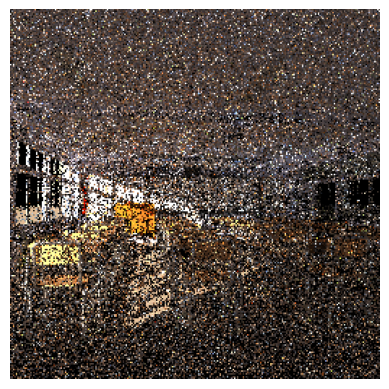

In [11]:
mi.set_variant('scalar_rgb')
upDatePathGraph(10)
L =  ReConstructImgByPathGraph(PathGraph)
plt.imshow(L**(1.0/2.2)); plt.axis('off')

In [ ]:
        

#### 如何得到最有效的路径？？？
# 可以考虑修改路径追踪采样方案，来得到最有效的路径

### 方案1 - 提取路径空间信息进行全局光照预测
# 1. 筛选出有效路径向量，利用自编码器进行编码。编码后的向量结合屏幕空间信息进行全局光照预测
# 2. 用Unet对屏幕空间信息编码，提取每个着色点的信息，再Concat编码后的向量，用MLP做每个着色点上的全局光照结果预测
# 3. 相当于对TVCG上那篇论文的改进，进一步结合了路径空间信息

### 方案2 - 将路径图扩展到时间域
### 重难点在于，之前的路径可能已经失效，